# Scraping filmweb.com page

 Grzegorz Kowalczyk, Kamil Matuszelański 387078

*Author of this file - Kamil Matuszelański*

### Website description

Filmweb is a website on which users can obtain information about movies. It also provides convenient way to rate movies. The users are able to give ratings from 1 to 10 stars. The website also provides social networking functions. Users can add friends and compare their ratings. One of the convenient features is the ability to log in with facebook, and obtain friends suggestions from there. 

### Project details

Filweb.com page required a dynamic approach, thus **we have prepared scrapers using selenium and scrapy libraries**. 

The main goal of the scraper was to obtain as much information about rated movies (by any users) as possible. Thus, our scraper consists of 2 parts:

1. Scraping list of particular friends. After getting that list, scraping list of friends' friends (and continue). 
2. For each user obtained from previous step, scraping list of movies rated by that user.

It is possible to see only 30 movies of user for which we are not friends with. Thus, to provide full information about friends' movies rated, we have added login with facebook feature. This is possible to do only with javascript enabled, as Facebook authentication mechanisms are suspicious about scrapers usage, and the page refused connection without a selenium browser running. The other reason for using interactive approach was scraping list of friends. This subpage requires "infinite scrolling" to show all friends of a particular user.  

#### Scrapy part

To obtain interactivity with scrapy, we have used scrapy-selenium library. As using scrapy with selenium as middleware is very slow we have tried to limit the work done with scrapy-selenium. There are 3 spiders in total:

- `login`
- `friends`
- `movies`.

To run the main movies part and scrape full information about ratings, being logged in with facebook was needed. The mechanism is to do login part with scrapy selenium, save cookies obtained from that request to an external file (`cookies.json`), and use these cookies in running movies part. 

After running movies scraper, some data cleaning was needed. More convenient was to do it in a separate file. The script process_data.py loads movies.csv and saves movies_cleaned.csv. 

### Basic data analysis

Obtained dataset is presented below. In the csv provided there are ~27 thousand ratings: The scraped information includes details:

- Internal filmweb movie id
- Average rating from all site users
- Number of votes 
- Movie title
- Year of production
- User who has given the rating
- 1-10 rating
- Date of rating

In [27]:
import pandas as pd
import seaborn as sns

movies = pd.read_csv('movies_cleaned.csv')
movies = movies.drop(movies.columns[0], axis = 1)
movies.head()

,movie_id,movie_rating_avg,movie_rating_no,movie_title,movie_year,user_rating,user_rated_date,user_name,user_page
0,31581,8.2,15194.0,Świadek oskarżenia,1957,9,2020-04-26,filiphancke,1
1,490965,7.2,38955.0,Mikołajek,2009,7,2020-04-26,filiphancke,1
2,792989,6.7,28284.0,Nieoszlifowane diamenty,2019,8,2020-04-26,filiphancke,1
3,11756,7.1,19939.0,Wojna państwa Rose,1989,7,2020-04-26,filiphancke,1
4,30726,7.2,12458.0,West Side Story,1961,8,2020-01-02,greyshh,1


Number of movies rated by each user:

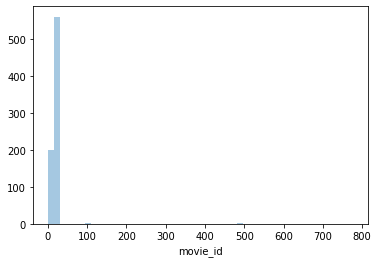

In [28]:
no_movies_by_user = movies.groupby('user_name').movie_id.count().reset_index().sort_values(by = 'movie_id', ascending = False)
sns.distplot(no_movies_by_user.movie_id, kde = False)

Most rated movies:

In [29]:
no_movies_ratings = movies.movie_title.value_counts().reset_index()
no_movies_ratings.head(10)

,index,movie_title
0,Joker,158
1,Boże Ciało,100
2,Parasite,97
3,Green Book,87
4,Nietykalni,84
5,Forrest Gump,83
6,Historia małżeńska,82
7,Skazani na Shawshank,77
8,Pewnego razu... w Hollywood,75
9,Bohemian Rhapsody,73


Number of ratings and mean rating. Movies below 5 ratings were dropped:

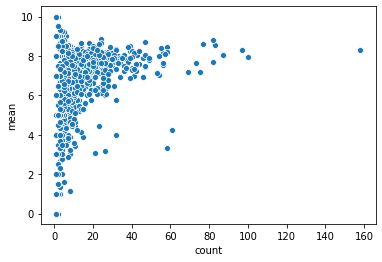

In [30]:
sns.scatterplot(x = 'count', y = 'mean', data = movies.groupby('movie_id')['user_rating'].agg(['mean', 'count']).reset_index())

#### Running instructions


To run both parts, first thing to do is copy file geckodriver.exe to a folder with current conda/pip environment. The scraper will work at its full potential for filmweb users with enabled facebook authentication, however running without login is also possible. To run selenium part: 

```
cd selenium
python run.py
```

Outputs are saved in selenium/data file. To run scrapy part, first set needed parameters (like facebook login credentials) in file a/const.py. After that, run the following commands from the terminal:

```
cd a

scrapy crawl login
scrapy crawl friends --set CLOSESPIDER_PAGECOUNT=10 -o data/friends.csv

scrapy crawl movies -o data/movies.csv
python process_data.py
```